In [277]:
import numpy as np
from itertools import product

class SRModel(object):
    '''
        SR model based on Experiment 2 KTH, SR, AM SPI Mechanism
    
    '''
    def __init__(self, **kwargs):
        
        self.numPlayers = 2
        self.value = np.array([200, 250, 320])
        self.cost = np.array([130, 80, 10])
        
        # number of individual actions
        self.numiActions = 27
        self.buyerActions = np.array(list(product([0, 1, 2], repeat=3)))
        self.sellerActions = np.array(list(product([0, 1, 2], repeat=3)))
        
        self.memory = kwargs.get('memory', 0)
        self.true_value_index = kwargs.get('true_value',2)
        self.true_cost_index = kwargs.get('true_cost',2)
        self.trueValue = self.value[self.true_value_index]
        self.trueCost = self.cost[self.true_cost_index]
        
        self.delta = kwargs.get('delta',0.95)
        
        self.reward = 300
        self.penalty = -300
        
        self.buyerInvestment = 0
        self.sellerInvestment = 0       
#         self.trueValue = self.init_TrueValue(self.sellerInvestment)
#         self.trueCost = self.init_TrueCost(self.buyerInvestment)
        
        
        self.numActions = self.numiActions ** self.numPlayers
        self.numStates = self.numiActions ** (self.numPlayers * self.memory)
        
        self.indexActions = self.init_indexActions()
        self.Prices = self.init_Prices()
        self.Profits,self.Penalty = self.init_Profits()

        # QL

        self.lengthStates = self.numPlayers * self.memory
        self.lengthStrategies = self.numPlayers * self.numStates
        
        self.Q = self.init_Q()

        self.cActions = self.init_cActions()
        
        
    def init_indexActions(self):
        
        indexActions = []
        for i in range(self.numActions):
            
            indexActions.append(self.convertNumberBase(i, self.numiActions, self.numPlayers))
            
        indexActions = np.array(indexActions)
        
        return indexActions

    def init_TrueValue(self, i):
        if i == 0:
            return 200
        elif i == 25:
            return 250
        else:
            return 320

    def init_TrueCost(self, i):
        if i == 0:
            return 130
        elif i == 25:
            return 80
        else:
            return 10
    
    def init_Prices(self):
        
        pricesArray = np.zeros((3, 3))
        for cb in range(0, 3):
            for vs in range(0, 3):
                
                # (vs-200) - (130-cb) + 165
                
                pricesArray[cb][vs] = (self.value[vs] - 200) - (130 - self.cost[cb]) + 165
                
        return pricesArray

    
    def init_Profits(self):
        Profits = np.zeros((self.numActions, self.numPlayers))
        Penalty = np.zeros((self.numActions, self.numPlayers))        
        Actions = np.zeros((self.numActions, 6))
        
        for i in range(self.numActions):
            b = int(self.indexActions[i][0])
            s = int(self.indexActions[i][1])
            
            vb, cb, vb_a = self.buyerActions[b]
            vs, cs, cs_a = self.sellerActions[s]
            penalb = 0
            penals = 0
            
            Actions[i] = vb, cb, vb_a, vs, cs, cs_a
            
            if (vb == vs) and (cb == cs):
                # if all report coincide
                
                # profit for buyer: true value - price - investment_buyer
                pb = self.trueValue - self.Prices[cb][vs] - self.buyerInvestment
                
                # profit for seller: price - true cost - investment_seller
                ps = self.Prices[cb][vs] - self.trueCost - self.sellerInvestment               
                
            elif (vb != vs) and (cb == cs):
                # only the value reports differ
                # buyer enters into arbitration stage
                
                if vb_a == 0:
                    # no_trade
                    pb = 0 - self.buyerInvestment
                    ps = 0 - self.sellerInvestment
                    
                elif vb_a == 1:
                    pb = 0.5 * 0 + 0.5 * (self.trueValue - 205) - self.buyerInvestment
                    ps = 0.5 * 0 + 0.5 * (205 - self.trueCost) - self.sellerInvestment
                    
                else:
                    pb = 0.5 * (self.trueValue - 205) + 0.5 * (self.trueValue - 255) - self.buyerInvestment
                    ps = 0.5 * (255 - self.trueCost) + 0.5 * (205 - self.trueCost) - self.sellerInvestment

                # buyers is fined 300
                pb = pb +self.penalty
                penalb = self.penalty
                # the seller is rewarded a bonus of 300 if the second report of 
                # the buyer matches the first stage report
                # of seller. In other cases, the seller is also fined 300.
                
                
                if vb_a == vs:
                    ps = ps + self.reward
                    penals = self.reward
                    
                else:
                    ps = ps + self.penalty
                    penals = self.penalty
                    
            elif (vb == vs) and (cb != cs):
                # only the cost reports differ
                # seller enters into arbitration stage
                
                if cs_a == 0:
                    # no_trade
                    pb = 0 - self.buyerInvestment
                    ps = 0 - self.sellerInvestment
                    
                elif cs_a == 1:
                    pb = 0.5 * 0 + 0.5 * (self.trueValue - 125) - self.buyerInvestment
                    ps = 0.5 * 0 + 0.5 * (125 - self.trueCost) - self.sellerInvestment
                    
                else:
                    pb = 0.5 * (self.trueValue - 125) + 0.5 * (self.trueValue - 75) - self.buyerInvestment
                    ps = 0.5 * (125 - self.trueCost) + 0.5 * (75 - self.trueCost) - self.sellerInvestment

                # seller is fined 300
                ps = ps + self.penalty
                penals = self.penalty
                # the buyer is rewarded a bonus of 300 if the second report of 
                # the seller matches the first stage report
                # of buyer. In other cases, the buyer is also fined 300.
                
                if cs_a == cb:
                    pb = pb + self.reward
                    penalb = self.reward
                    
                else:
                    pb = pb + self.penalty
                    penalb = self.penalty
                    
            else:
                if vb_a == 0:
                    # no_trade
                    pb1 = 0 - self.buyerInvestment
                    ps1 = 0 - self.sellerInvestment
                    
                elif vb_a == 1:
                    pb1 = 0.5 * 0 + 0.5 * (self.trueValue - 205) - self.buyerInvestment
                    ps1 = 0.5 * 0 + 0.5 * (205 - self.trueCost) - self.sellerInvestment
                    
                else:
                    pb1 = 0.5 * (self.trueValue - 205) + 0.5 * (self.trueValue - 255) - self.buyerInvestment
                    ps1 = 0.5 * (255 - self.trueCost) + 0.5 * (205 - self.trueCost) - self.sellerInvestment
                    
                if vb_a == vs:
                    ps1 = ps1 + self.reward
                    penals = self.reward

                if cs_a == 0:
                    # no_trade
                    pb2 = 0 - self.buyerInvestment
                    ps2 = 0 - self.sellerInvestment
                    
                elif cs_a == 1:
                    pb2 = 0.5 * 0 + 0.5 * (self.trueValue - 125) - self.buyerInvestment
                    ps2 = 0.5 * 0 + 0.5 * (125 - self.trueCost) - self.sellerInvestment
                    
                else:
                    pb2 = 0.5 * (self.trueValue - 125) + 0.5 * (self.trueValue - 75) - self.buyerInvestment
                    ps2 = 0.5 * (125 - self.trueCost) + 0.5 * (75 - self.trueCost) - self.sellerInvestment
                    
                if cs_a == cb:
                    pb2 = pb2 + self.reward
                    penalb = self.reward

                pb = 0.5 * (pb1 + pb2) + self.penalty
                ps = 0.5 * (ps1 + ps2) + self.penalty
                penalb = penalb + self.penalty
                penals = penals + self.penalty
                
            Profits[i] = [pb, ps]
            Penalty[i] = [penalb,penals]
#         action_df = pd.DataFrame(Actions)

#         profit_df = pd.DataFrame(Profits)

        return Profits,Penalty

    
    def init_Q(self):
        Q = np.zeros((self.numActions, self.numiActions, self.numPlayers))
        for iReport in range(self.numiActions):
            
            den = np.count_nonzero(self.indexActions == iReport,axis = 0,keepdims = True)*(1-self.delta)
            #print(den)
            Q[:, iReport,:] = np.ma.array(self.Profits,
                                mask=(self.indexActions != iReport)).sum(axis = 0) / den
        return Q


    def init_cActions(self):
        """Initialize cActions (used for q-learning)"""
        
        x = np.arange(self.numPlayers - 1, -1, -1)
        cActions = self.numiActions ** x
        
        return cActions
    
    @staticmethod
    def convertNumberBase(n, b, l):
        '''
        Converts an integer n from base 10 to base b,
        generating a vector of integers of length l
        '''
        tmp = n
        ans = np.zeros(l)
        for i in range(1, l+1):
            ans[l-i] = int(tmp % b)
            tmp = np.floor(tmp/b)
        return ans



    

In [278]:
sr = SRModel()
sr.Q.shape,sr.Profits.shape

((729, 27, 2), (729, 2))

In [283]:
import numpy as np

# from SRModel import SRModel

    
class SR_Qlearning(object):
    '''
        Qlearning based on SR model
    '''
    def __init__(self, **kwargs):

        self.delta = kwargs.get('delta', 0.95)

        self.convergedtime = kwargs.get('convergedtime',500)
        self.numSessions = kwargs.get('numSessions',1)
        self.maxIters = kwargs.get('maxIters',100000)
        self.true_value_index = kwargs.get('true_value',1)
        self.true_cost_index = kwargs.get('true_cost',1)
        self.game = SRModel(delta = self.delta,true_value = self.true_value_index,
                           true_cost = self.true_cost_index)
        self.alpha = kwargs.get('alpha', 0.25) * np.ones(self.game.numPlayers)
        self.beta = kwargs.get('beta', 0.0005) * np.ones(self.game.numPlayers)
        self.initial_state = kwargs.get('initial_state',0)

        
        
        self.delta = kwargs.get('delta',0.95)
        
               
    def computePPrime(self, strategyPrime, iters):
        
        pPrime = np.zeros(self.game.numPlayers)
        #  Greedy with probability 1-epsilon, with exponentially decreasing epsilon
        
        for iPlayer in range(self.game.numPlayers):
            
            if np.random.uniform(0,1) < np.exp(-self.beta[iPlayer]*iters):

                pPrime[iPlayer] = np.floor(self.game.numiActions*np.random.uniform(0,1))
            else:
                pPrime[iPlayer] = strategyPrime[iPlayer]
                
        return pPrime


    def q_learning(self):

        # Initializing various quantities

        indexStrategies = np.zeros((self.game.numPlayers,self.numSessions))

        indexConverge = np.zeros((self.game.numPlayers,self.numSessions))
        
        self.profit_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)
        self.penalty_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)
        
        self.state_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers,3),np.nan)

        # Loop over numSessions
        for iSession in range(self.numSessions):
            
            
            # Learning Phase
            
            # Initialization
            self.Q = self.game.Q.copy()
            self.strategyPrime = np.zeros(self.game.numPlayers)
            maxVal = np.zeros(self.game.numPlayers)
            strategyPrime = np.floor(np.random.uniform(0,1,(2))*self.game.numiActions)   

            state = int(np.sum(self.game.cActions*strategyPrime))   
            
            # Loop
            itersInStrategy = 0
            convergedSession = -1
            
            strategyFix = np.zeros(self.game.numPlayers)
            
            for iters in range(self.maxIters):
                
                # Iterations counter
                
                for iPlayer in range(self.game.numPlayers):
                    
                    temp_q = self.Q[state,:,iPlayer]
                    #print(iters,temp_q)
                    maxVal[iPlayer] = np.max(temp_q)
                    #print(iters,maxVal)

                    strategyPrimeList = np.where(temp_q == maxVal[iPlayer])[0]
                    #print(iters,strategyPrimeList)
                    
                    u = np.random.uniform(0, 1)
                    strategyPrime[iPlayer] = strategyPrimeList[int(len(strategyPrimeList)*u)]
     
                state1 = int(np.sum(self.game.cActions*strategyPrime))     
                pPrime = self.computePPrime(strategyPrime, iters)
                    
                for iPlayer in range(self.game.numPlayers):
                    
                    # Q matrices and strategies update
                    oldq = self.Q[state, int(pPrime[iPlayer]), iPlayer]
                    newq = oldq + self.alpha[iPlayer] * (self.game.Profits[state1, iPlayer] + \
                                                self.delta * maxVal[iPlayer] - oldq)
                    #print('pppppp',state1)
                    self.Q[state, int(pPrime[iPlayer]), iPlayer] = newq
                    
                state = state1
                # Assessing convergence
                vb, cb, vb_a = self.game.buyerActions[int(strategyPrime[0])]
                vs, cs, cs_a = self.game.sellerActions[int(strategyPrime[1])]
                
                vb_1, cb_1, vb_a_1 = self.game.buyerActions[int(pPrime[0])]
                vs_1, cs_1, cs_a_1 = self.game.sellerActions[int(pPrime[1])]                
                if vb == vb_1 and cb == cb_1 and vs == vs_1 and cs == cs_1:
                    itersInStrategy = itersInStrategy + 1
                
                else:
                    itersInStrategy = 1

                # Check for convergence in strategy
                if convergedSession == -1:
                    # Maximum number of iterations exceeded
                    if iters >= self.maxIters - 1:
                        convergedSession = 0


                    if itersInStrategy == self.convergedtime:
                        convergedSession = 1

                    strategyFix = strategyPrime.copy()               #testing

                # Check for loop exit criteria
                if convergedSession != -1:
                    break
                # if no converge yet, update and iterate
    
            indexConverge[:,iSession] = (convergedSession, iters)
            indexStrategies[:,iSession] = strategyFix
            self.indexConverge = indexConverge
            self.indexStrategies = indexStrategies
            #print(iSession,convergedSession)

        return indexConverge, indexStrategies



    

In [293]:
K = SR_Qlearning(numSessions = 1,delta = 0.95,alpha = 0.25,beta = 0.0005,
                 true_value = 1,true_cost = 1,
                 convergedtime = 500,maxIters = 100000)
print(K.q_learning())

print(K.game.buyerActions[int(K.indexStrategies[0][0])],K.game.buyerActions[int(K.indexStrategies[1][0])])

(array([[1.0000e+00],
       [1.1769e+04]]), array([[ 8.],
       [20.]]))
[0 2 2] [2 0 2]


In [192]:
K = SR_Qlearning(numSessions = 1,delta = 0.95,alpha = 0.25,beta = 0.0005,
                 true_value = 2,true_cost = 2,
                 convergedtime = 500,maxIters = 100000)
K.q_learning()

(array([[1.0000e+00],
        [1.3007e+04]]),
 array([[12.],
        [12.]]))

In [148]:
print(R[1])
print(K.game.buyerActions[int(K.indexStrategies[0][0])],K.game.buyerActions[int(K.indexStrategies[1][0])])

[[17.]
 [14.]]
[1 1 1] [1 1 1]


In [101]:
indexes2 = np.where(~np.isnan(K.state_list[0,:,1]))[0][-1] + 1
for i in range(indexes2):
    print(K.state_list[0,i,0],K.state_list[0,i,1])

[1. 0. 0.] [0. 0. 2.]
[1. 2. 2.] [2. 1. 1.]
[0. 2. 2.] [1. 2. 2.]
[1. 1. 1.] [0. 0. 0.]
[2. 0. 0.] [2. 0. 1.]
[0. 2. 1.] [2. 0. 1.]
[2. 2. 1.] [1. 0. 1.]
[1. 0. 1.] [2. 1. 1.]
[0. 0. 1.] [0. 1. 1.]
[0. 0. 1.] [1. 1. 1.]
[0. 1. 0.] [1. 2. 2.]
[0. 0. 1.] [1. 0. 2.]
[0. 2. 0.] [1. 2. 2.]
[1. 2. 0.] [2. 1. 1.]
[2. 2. 0.] [2. 1. 0.]
[0. 1. 1.] [0. 2. 2.]
[1. 2. 2.] [1. 1. 1.]
[1. 2. 0.] [2. 0. 1.]
[2. 1. 1.] [0. 2. 2.]
[1. 2. 2.] [2. 0. 0.]
[2. 2. 0.] [2. 2. 0.]
[1. 0. 1.] [2. 0. 2.]
[1. 2. 0.] [1. 0. 1.]
[2. 0. 2.] [0. 1. 0.]
[1. 1. 1.] [0. 0. 0.]
[0. 2. 1.] [2. 0. 0.]
[2. 0. 0.] [2. 0. 1.]
[0. 1. 1.] [2. 2. 0.]
[2. 2. 2.] [1. 1. 2.]
[0. 2. 1.] [1. 1. 2.]
[0. 2. 0.] [1. 1. 0.]
[0. 2. 2.] [2. 2. 1.]
[1. 2. 1.] [1. 0. 1.]
[2. 2. 1.] [0. 2. 1.]
[2. 0. 0.] [2. 1. 2.]
[1. 0. 0.] [1. 0. 1.]
[1. 2. 1.] [0. 2. 2.]
[0. 0. 1.] [1. 0. 2.]
[0. 2. 0.] [2. 1. 1.]
[1. 0. 0.] [1. 2. 0.]
[2. 1. 0.] [1. 1. 2.]
[0. 2. 1.] [0. 2. 0.]
[1. 1. 1.] [0. 2. 2.]
[0. 1. 0.] [2. 2. 0.]
[1. 0. 0.] [2. 0. 1.]
[1. 2. 0.]

[0. 1. 0.] [2. 2. 2.]
[0. 2. 1.] [2. 0. 1.]
[2. 1. 1.] [0. 0. 0.]
[2. 1. 1.] [0. 0. 1.]
[2. 0. 0.] [0. 0. 2.]
[0. 0. 1.] [0. 0. 1.]
[2. 0. 1.] [1. 0. 0.]
[1. 1. 0.] [0. 1. 2.]
[1. 2. 2.] [0. 1. 0.]
[2. 1. 1.] [2. 0. 1.]
[2. 1. 1.] [0. 0. 0.]
[0. 1. 1.] [1. 0. 0.]
[0. 2. 2.] [2. 0. 1.]
[2. 1. 1.] [0. 0. 1.]
[2. 0. 1.] [1. 1. 0.]
[0. 0. 2.] [1. 1. 2.]
[0. 2. 1.] [2. 1. 2.]
[2. 0. 2.] [2. 0. 0.]
[0. 0. 1.] [2. 1. 0.]
[0. 2. 1.] [1. 1. 2.]
[2. 1. 1.] [1. 0. 0.]
[2. 1. 1.] [1. 0. 0.]
[0. 0. 0.] [1. 1. 2.]
[0. 1. 0.] [1. 1. 2.]
[1. 0. 1.] [2. 2. 2.]
[2. 2. 1.] [2. 0. 0.]
[1. 1. 2.] [0. 1. 2.]
[0. 0. 1.] [1. 0. 1.]
[2. 2. 0.] [1. 2. 2.]
[1. 1. 2.] [1. 2. 2.]
[1. 1. 1.] [2. 0. 1.]
[0. 2. 0.] [0. 1. 0.]
[1. 2. 2.] [2. 1. 2.]
[1. 0. 0.] [2. 0. 2.]
[2. 1. 1.] [1. 1. 2.]
[2. 1. 2.] [2. 0. 1.]
[1. 2. 0.] [1. 1. 2.]
[1. 0. 1.] [2. 2. 1.]
[2. 1. 2.] [2. 0. 0.]
[0. 2. 0.] [2. 0. 1.]
[2. 1. 1.] [1. 2. 2.]
[1. 2. 0.] [2. 0. 1.]
[0. 2. 1.] [2. 0. 1.]
[2. 1. 0.] [0. 2. 0.]
[1. 2. 0.] [1. 2. 2.]
[2. 0. 0.]

[2. 2. 1.] [2. 2. 2.]
[2. 2. 1.] [2. 2. 2.]
[1. 0. 2.] [1. 0. 1.]
[2. 2. 1.] [2. 2. 2.]
[0. 0. 2.] [1. 2. 0.]
[2. 2. 1.] [2. 2. 2.]
[0. 1. 1.] [2. 2. 2.]
[2. 2. 1.] [2. 2. 2.]
[2. 2. 1.] [1. 0. 0.]
[0. 2. 1.] [2. 0. 1.]
[0. 0. 0.] [1. 2. 2.]
[1. 1. 0.] [1. 1. 2.]
[0. 1. 0.] [2. 0. 1.]
[0. 0. 2.] [0. 0. 0.]
[1. 2. 0.] [2. 1. 1.]
[1. 2. 0.] [1. 2. 2.]
[0. 0. 2.] [1. 2. 2.]
[2. 0. 1.] [1. 1. 2.]
[1. 2. 1.] [2. 0. 1.]
[2. 1. 1.] [1. 1. 0.]
[0. 1. 2.] [0. 1. 2.]
[1. 1. 1.] [1. 2. 2.]
[2. 0. 1.] [2. 0. 0.]
[2. 1. 1.] [1. 2. 2.]
[2. 2. 0.] [1. 1. 0.]
[0. 2. 1.] [1. 0. 0.]
[2. 1. 1.] [1. 1. 1.]
[1. 2. 0.] [1. 1. 0.]
[0. 2. 1.] [2. 0. 1.]
[2. 1. 1.] [1. 2. 2.]
[1. 2. 0.] [2. 1. 1.]
[0. 0. 2.] [1. 0. 2.]
[2. 1. 1.] [1. 2. 2.]
[1. 2. 0.] [2. 1. 2.]
[2. 1. 0.] [2. 0. 1.]
[2. 1. 1.] [1. 2. 2.]
[1. 0. 2.] [1. 2. 1.]
[0. 2. 1.] [0. 1. 2.]
[0. 2. 1.] [1. 2. 2.]
[1. 1. 0.] [2. 1. 0.]
[1. 1. 0.] [1. 1. 1.]
[0. 1. 2.] [1. 1. 2.]
[0. 1. 1.] [2. 2. 1.]
[2. 2. 0.] [1. 0. 1.]
[0. 2. 1.] [2. 0. 1.]
[2. 1. 0.]

[2. 0. 1.] [2. 1. 1.]
[0. 2. 1.] [2. 0. 1.]
[2. 1. 0.] [2. 2. 1.]
[1. 0. 2.] [0. 1. 1.]
[0. 2. 1.] [0. 0. 0.]
[2. 1. 2.] [0. 0. 0.]
[0. 0. 0.] [2. 0. 1.]
[2. 0. 1.] [2. 1. 1.]
[0. 2. 1.] [2. 0. 1.]
[2. 1. 0.] [1. 2. 0.]
[0. 2. 0.] [0. 1. 1.]
[0. 2. 1.] [0. 2. 2.]
[1. 1. 0.] [1. 2. 2.]
[1. 0. 1.] [1. 2. 2.]
[0. 2. 1.] [2. 0. 1.]
[2. 1. 0.] [1. 2. 0.]
[1. 0. 2.] [1. 1. 1.]
[2. 1. 2.] [2. 0. 1.]
[2. 1. 2.] [0. 2. 2.]
[2. 1. 2.] [2. 0. 1.]
[2. 1. 2.] [2. 2. 1.]
[1. 1. 1.] [2. 0. 1.]
[2. 0. 2.] [1. 0. 2.]
[1. 1. 0.] [2. 0. 1.]
[2. 1. 0.] [0. 1. 1.]
[1. 0. 2.] [1. 0. 1.]
[2. 1. 2.] [2. 0. 1.]
[0. 1. 1.] [2. 2. 1.]
[2. 1. 2.] [2. 0. 1.]
[2. 1. 2.] [2. 2. 1.]
[2. 1. 2.] [1. 2. 0.]
[2. 1. 2.] [0. 0. 0.]
[0. 1. 1.] [2. 2. 0.]
[2. 1. 2.] [2. 2. 1.]
[1. 1. 1.] [2. 1. 1.]
[2. 0. 2.] [1. 0. 2.]
[0. 2. 2.] [2. 0. 1.]
[2. 1. 0.] [1. 2. 0.]
[1. 0. 2.] [0. 1. 1.]
[1. 0. 2.] [2. 0. 1.]
[0. 1. 0.] [2. 0. 1.]
[0. 1. 0.] [2. 0. 2.]
[0. 2. 1.] [2. 0. 1.]
[1. 2. 1.] [1. 2. 0.]
[1. 0. 2.] [0. 1. 1.]
[0. 2. 0.]

[1. 2. 1.] [1. 2. 2.]
[1. 2. 1.] [1. 2. 2.]
[1. 2. 1.] [0. 0. 2.]
[0. 2. 0.] [1. 2. 2.]
[1. 2. 1.] [1. 2. 2.]
[1. 2. 1.] [0. 2. 0.]
[2. 0. 1.] [2. 1. 0.]
[2. 0. 1.] [0. 2. 1.]
[0. 2. 1.] [2. 0. 2.]
[0. 2. 1.] [2. 0. 1.]
[2. 1. 0.] [1. 2. 2.]
[1. 2. 1.] [1. 2. 2.]
[1. 2. 1.] [0. 2. 0.]
[2. 0. 1.] [2. 1. 0.]
[2. 0. 1.] [0. 2. 1.]
[0. 2. 1.] [2. 0. 2.]
[0. 2. 1.] [2. 0. 1.]
[2. 1. 0.] [1. 1. 0.]
[1. 2. 1.] [1. 2. 2.]
[1. 2. 1.] [0. 2. 0.]
[2. 0. 1.] [1. 2. 2.]
[2. 0. 1.] [0. 2. 1.]
[0. 2. 1.] [2. 0. 2.]
[0. 2. 1.] [2. 0. 1.]
[2. 1. 0.] [1. 2. 2.]
[1. 2. 1.] [1. 2. 2.]
[1. 2. 1.] [0. 2. 0.]
[2. 0. 1.] [2. 1. 0.]
[2. 0. 1.] [0. 2. 1.]
[0. 2. 1.] [2. 0. 2.]
[0. 2. 1.] [2. 0. 1.]
[0. 0. 1.] [1. 2. 2.]
[1. 2. 1.] [1. 2. 2.]
[1. 2. 1.] [1. 2. 2.]
[1. 2. 1.] [1. 2. 2.]
[2. 1. 0.] [1. 2. 2.]
[1. 2. 1.] [1. 2. 2.]
[1. 2. 1.] [0. 2. 0.]
[2. 0. 1.] [2. 1. 0.]
[2. 0. 1.] [0. 2. 1.]
[0. 2. 1.] [2. 0. 2.]
[0. 2. 1.] [2. 0. 1.]
[2. 1. 0.] [1. 2. 2.]
[1. 2. 1.] [0. 1. 2.]
[1. 2. 1.] [2. 0. 1.]
[0. 1. 0.]

[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 2. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[0. 0. 1.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[0. 1. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [0. 1. 2.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 0. 0.]
[2. 0. 2.] [2. 2. 2.]
[2. 0. 2.] [2. 0. 0.]
[0. 1. 2.] [2. 0. 0.]
[1. 2. 1.] [2. 0. 0.]
[0. 2. 2.] [2. 0. 0.]
[0. 0. 0.] [0. 2. 1.]
[2. 2. 1.] [2. 0. 1.]
[0. 1. 2.] [1. 1. 2.]
[1. 2. 0.] [2. 0. 0.]
[0. 2. 1.] [2. 0. 1.]
[2. 1. 0.] [1. 2. 2.]
[1. 2. 1.]

[1. 2. 2.] [1. 2. 2.]
[0. 1. 2.] [1. 2. 2.]
[0. 1. 2.] [1. 2. 2.]
[0. 2. 1.] [2. 0. 1.]
[2. 1. 0.] [1. 2. 2.]
[1. 2. 1.] [1. 2. 2.]
[1. 2. 1.] [1. 2. 1.]
[1. 2. 1.] [1. 2. 2.]
[1. 2. 1.] [1. 2. 1.]
[1. 2. 1.] [1. 2. 2.]
[1. 2. 1.] [1. 2. 1.]
[1. 2. 1.] [1. 2. 2.]
[1. 2. 1.] [1. 2. 1.]
[1. 2. 1.] [1. 2. 1.]
[1. 2. 1.] [1. 2. 1.]
[1. 2. 1.] [1. 2. 1.]
[1. 2. 1.] [1. 2. 1.]
[1. 2. 1.] [2. 0. 1.]
[1. 2. 1.] [1. 2. 1.]
[1. 2. 2.] [1. 2. 1.]
[1. 2. 2.] [2. 2. 0.]
[0. 2. 1.] [2. 0. 1.]
[2. 1. 0.] [2. 2. 0.]
[1. 2. 1.] [0. 0. 1.]
[1. 2. 1.] [1. 2. 1.]
[1. 2. 1.] [1. 2. 1.]
[1. 2. 1.] [1. 2. 1.]
[1. 2. 1.] [1. 2. 1.]
[1. 2. 1.] [1. 2. 1.]
[1. 2. 1.] [1. 2. 1.]
[2. 1. 2.] [1. 2. 1.]
[1. 2. 1.] [1. 2. 1.]
[1. 2. 1.] [1. 2. 2.]
[2. 0. 2.] [1. 2. 1.]
[0. 2. 1.] [2. 0. 1.]
[2. 1. 0.] [1. 2. 2.]
[1. 2. 1.] [1. 2. 2.]
[1. 2. 1.] [1. 2. 2.]
[1. 2. 1.] [1. 2. 2.]
[1. 2. 1.] [1. 2. 2.]
[1. 2. 1.] [1. 2. 2.]
[1. 2. 1.] [1. 2. 2.]
[1. 2. 1.] [2. 2. 2.]
[1. 2. 1.] [1. 2. 2.]
[2. 0. 2.] [1. 2. 2.]
[0. 2. 1.]

[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[1. 0. 0.]

[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.]

[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.] [2. 1. 0.]
[2. 1. 2.]

[0. 1. 1.] [1. 0. 1.]
[2. 2. 2.] [1. 0. 1.]
[0. 2. 1.] [2. 0. 1.]
[2. 1. 0.] [1. 2. 2.]
[1. 2. 1.] [0. 1. 1.]
[0. 1. 2.] [1. 1. 0.]
[1. 0. 0.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[2. 2. 2.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 2.]
[0. 1. 1.] [0. 1. 1.]
[0. 1. 1.] [1. 1. 0.]
[0. 2. 1.] [1. 1. 0.]
[2. 2. 1.] [2. 0. 1.]
[2. 0. 0.]

[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.] [0. 1. 0.]
[0. 1. 1.]

In [8]:

K.game.buyerActions[int(K.indexStrategies[0][0])],K.game.buyerActions[int(K.indexStrategies[1][0])]

(array([0, 2, 2]), array([1, 1, 1]))

In [ ]:
true_state_list = np.array([[0,0],[0,1],[0,2],[1,0],[1,1],[1,2],[2,0],[2,1],[2,2]])
lists = np.full((19,19),np.nan)
for i in range(1,20):
    i_id = i/20
    for j in range(1,20):
        j_id = j/20
        indexs = 0
        for true_state in true_state_list:
            indexs0 = 0
            for iters in range(10):
                K = SR_Qlearning(numSessions = 1,delta = i_id,alpha = j_id,beta = 0.0005,
                                 true_value = int(true_state[0]),true_cost = int(true_state[1]),
                                 convergedtime = 500,maxIters = 100000)
                R = K.q_learning()[1] 
                temp1 = K.game.buyerActions[int(R[0][0])]
                temp2 = K.game.buyerActions[int(R[1][0])]
#                 print('true state',true_state[0],true_state[1],\
#                 'buyer',temp1[0],temp1[1],\
#                 'seller',temp2[0],temp2[1])
                if true_state[0]== temp1[0] and true_state[0] == temp2[0] and \
                    true_state[1]== temp1[1] and true_state[1] == temp2[1]:
                    indexs0+=1
                    if indexs0 >=4:
                        indexs+=1
                        break

        print(i_id,j_id,indexs)
        lists[i-1][j-1] = indexs
        if indexs == 9:
            print('congratulations',i_id,j_id)
                    
            

0.05 0.05 0
0.05 0.1 0
0.05 0.15 0
0.05 0.2 0
0.05 0.25 0
0.05 0.3 0
0.05 0.35 0
0.05 0.4 0
0.05 0.45 0
0.05 0.5 0
0.05 0.55 0
0.05 0.6 0
0.05 0.65 0
0.05 0.7 0
0.05 0.75 0
0.05 0.8 0
0.05 0.85 0
0.05 0.9 0
0.05 0.95 0
0.1 0.05 0
0.1 0.1 0
0.1 0.15 0
0.1 0.2 0
0.1 0.25 0
0.1 0.3 0
0.1 0.35 0
0.1 0.4 0
0.1 0.45 0
0.1 0.5 0


Text(0.5, 1.0, 'penalty for SR model')

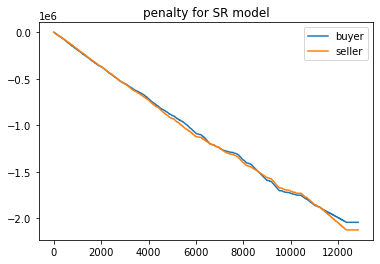

In [116]:
import matplotlib.pyplot as plt
plt.plot(K.penalty_list[0,:,0].cumsum())
plt.plot(K.penalty_list[0,:,1].cumsum())
plt.legend(labels=['buyer','seller'],loc='best')
plt.title('penalty for SR model')

Text(0.5, 1.0, 'profit for SR model')

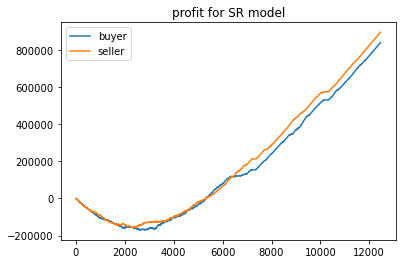

In [31]:
import matplotlib.pyplot as plt
plt.plot(K.profit_list[0,:,0].cumsum())
plt.plot(K.profit_list[0,:,1].cumsum())
plt.legend(labels=['buyer','seller'],loc='best')
plt.title('profit for SR model')

Text(0.5, 1.0, 'profit-penalty for SR model')

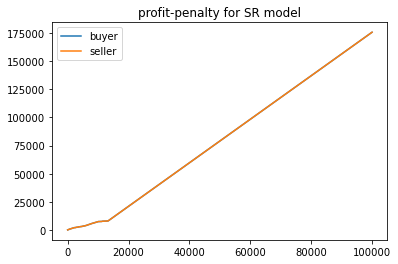

In [46]:
import matplotlib.pyplot as plt
plt.plot((K.profit_list[0,:,0].cumsum()-K.penalty_list[0,:,0].cumsum())/155)
plt.plot((K.profit_list[0,:,1].cumsum()-K.penalty_list[0,:,0].cumsum())/155)
plt.legend(labels=['buyer','seller'],loc='best')
plt.title('profit-penalty for SR model')

In [8]:
np.sum(K.penalty_list[0,:int(K.indexConverge[1,0]),0]!=0)/ \
    (np.sum(~np.isnan(K.penalty_list[0,:int(K.indexConverge[1,0]),0]))-500)

0.38

In [378]:
lists

array([[ 6.,  7., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan

In [381]:
np.save('./experiment data/lists.npy',np.array(lists))

In [23]:
from multiprocessing import Pool

def single_process(alpha):

    converge_list = [10000]
    beta_list = [0.0005]
    for cl in converge_list:
        df = pd.DataFrame(columns=['alpha','beta','total_sessions',
                                   'converged_times','i ndexStrategie','indexConverge'])
        path = 'SR_parallel_result'
        if not os.path.exists(path):
            os.mkdir(path)

        for beta in beta_list:
            temp_model = SR_Qlearning(alpha = alpha,beta = beta, convergedtime = cl)
            temo_model.q_learning()
            indexConverge,indexStrategies = q_learning()
            df = df.append({'alpha':alpha,'beta':beta,'total_sessions':kth.numSessions,
                            'converged_times':cl,'indexStrategie':indexStrategies,
                            'indexConverge':indexConverge },ignore_index=True)
            print('alpha:',alpha,' beta:',beta,' converged_times:',cl,' finish!')

        with open(path + '/' + 'a_'+ str(alpha) + 'b_'+ str(beta) + '_cl_' + str(cl) + '.pkl', 'wb') as f:
            pickle.dump(df, f)

def run_complex_operations(operation, input, pool):
    pool.map(operation, input)



In [24]:
processes_count = 10
     

alpha_list = np.linspace(0.025,0.25,2)
processes_pool = Pool(processes_count)
run_complex_operations(single_process,alpha_list , processes_pool)

Process SpawnPoolWorker-24:
Process SpawnPoolWorker-23:
Traceback (most recent call last):
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
Traceback (most recent call last):
AttributeError: Can't get attribute 'single_process' on <module '__main__' (built-in)>
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  F

KeyboardInterrupt: 

python3.9/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Process SpawnPoolWorker-29:
Traceback (most recent call last):
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/Users/manifect/opt/miniconda3/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Traceback (most recent call last